## MODELING

In [8]:
# !pip install xgboost
# !pip install lightgbm


From the previous notebooks we confirmed that there is skewness in our data that needs our attention. We will generate random sampling methods, the idea is we create two over sampling methods and one under sampling method. Then we create models using those sampling methods, so for each model we can expect three. 

Throughout this notebook, we can expect a few things to see when a model is built. AUC-ROC score followed by the ROC curve, and then we will make sense of confusion matrix and classification reports for each model. 

Our clients want us to have a model that tells us how many we correctly identified as having a heart disease. 

we would like to completely avoid any situations where the patient has heart disease, but our model classifies as him not having it i.e., aim for high recall.

Thus, the measure we will use to evaluate our models will be Recall. Recall is the fraction of the total amount of relevant instances that were actually retrieved, in simple terms, what percentage of actual positive predictions were correctly classified by the classifier. 

First we will import the modules, confirm that there is skewness in our target variable and go on about making sampling methods. 


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version

from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA

#Standardize a dataset along any axis. Center to the mean and component wise scale to unit variance.
from sklearn.preprocessing import scale


from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Construct a Pipeline from the given estimators.
from sklearn.pipeline import make_pipeline


from sklearn.feature_selection import SelectKBest, f_regression
import datetime


In [10]:
hearts = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\Personal Key Indicators of Heart Disease\\heart_2020_cleaned.csv")

In [11]:
hearts['HeartDisease'].value_counts(normalize = True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

In [12]:
X_train = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\X_train.csv")
X_test = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\X_test.csv")
y_train = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\y_train.csv")
y_test = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\y_test.csv")


In [13]:
print("\n")
print("X_train:", type(X_train), X_train.shape) 

# AJS:
print("\n")
print("X_test", type(X_test), X_test.shape) 

print("\n")
print("y_train", type(y_train), y_train.shape) 

print("\n")
print("y_test", type(y_test), y_test.shape) 




X_train: <class 'pandas.core.frame.DataFrame'> (239846, 50)


X_test <class 'pandas.core.frame.DataFrame'> (79949, 50)


y_train <class 'pandas.core.frame.DataFrame'> (239846, 1)


y_test <class 'pandas.core.frame.DataFrame'> (79949, 1)


We need to convert y_train & y_test into series instead of a DataFrame.

In [14]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [15]:
print("\n")
print("y_train", type(y_train), y_train.shape, len(y_train)) 

print("\n")
print("y_test", type(y_test), y_test.shape, len(y_test)) 



y_train <class 'pandas.core.series.Series'> (239846,) 239846


y_test <class 'pandas.core.series.Series'> (79949,) 79949


In [16]:
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(0    0.914403
 1    0.085597
 Name: HeartDisease, dtype: float64,
 0    0.914408
 1    0.085592
 Name: HeartDisease, dtype: float64)

Our y_train and y_test set are as skewed as our target varible. 

What we want to do is take the skewness off, build models using the data with no skewness and then test those models again on the skewed data. Such a problem that there is no skewness is very unlikely in the real data, hence why we want to preserve our test set, so we can apply our models to a real world like set.

### Over Sampling

#### Smote on training set

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 10)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


In [18]:
X_smote.shape, y_smote.shape


((438632, 50), (438632,))

In [19]:
y_smote.value_counts(normalize = True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

#### ADASYN

In [20]:
from imblearn.over_sampling import ADASYN

X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

In [21]:
X_adasyn.shape, y_adasyn.shape

((441820, 50), (441820,))

In [22]:
y_adasyn.value_counts(normalize = True)

1    0.503608
0    0.496392
Name: HeartDisease, dtype: float64

In [23]:
# X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn, y_adasyn, random_state=5)

In [24]:
# X_train_adasyn.shape, y_train_adasyn.shape, X_test_adasyn.shape, y_test_adasyn.shape

### Under Sampling

#### Random Under Sampler

In [25]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus, = rus.fit_resample(X_train, y_train)

X_rus.shape, y_rus.shape

((41060, 50), (41060,))

In [26]:
y_rus.value_counts(normalize = True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

After applying sampling method, The skewness is off and the count has been even to a 50/50 rather than a 92/8.

Our first model will be Random Forest, we will search for the best parameters using RandomizedSearchCV and then use those parameters to generate a model 

### Random Forest

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf = RandomForestClassifier()

In [29]:
rf_param_grid = {
                 'max_depth' : [4, 6, 8,10],
                 'n_estimators': range(1,10),
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10,20],
                 'min_samples_leaf': [1, 3, 10,18],
                 'bootstrap': [True, False],
                 
                 }

In [30]:
m_r = RandomizedSearchCV(param_distributions = rf_param_grid, 
                                    estimator = rf, scoring = "f1", 
                                    verbose = 0, n_iter = 100, cv = 5)

##### Random Forest - RUS

In [31]:
%time m_r.fit(X_rus, y_rus)

Wall time: 1min 5s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   scoring='f1')

In [32]:
m_r.best_score_

0.7510438526848399

In [33]:
m_r.best_params_

{'n_estimators': 7,
 'min_samples_split': 3,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [34]:
rf_bp = m_r.best_params_

In [35]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [36]:
rf_classifier.fit(X_rus, y_rus)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=3,
                       n_estimators=7)

In [37]:
y_test_pred_rf_rus = rf_classifier.predict(X_test)
print(accuracy_score(y_test_pred_rf_rus, y_test))

0.7414851968129683



 AUC-ROC: 0.7465196361240669


Text(0.5, 0, 'False Positive Rate')

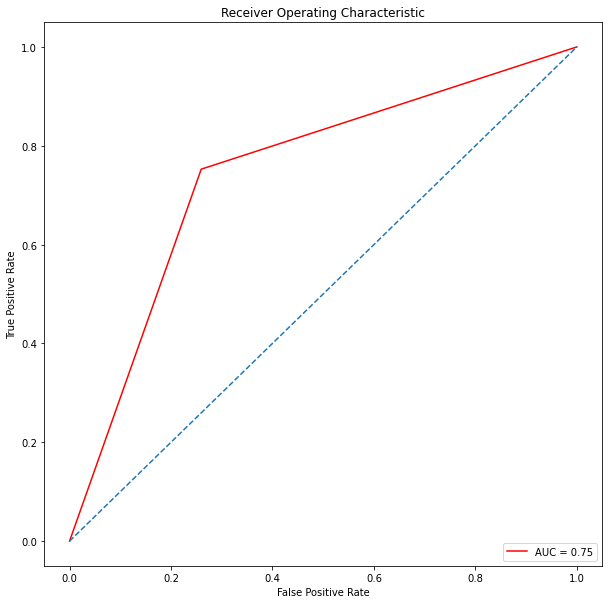

In [38]:
from sklearn import metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_test, y_test_pred_rf_rus))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_rf_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

The area under the curve is 0.76, which is significantly better than 0.55 which was generate from a basic logistic regression model.

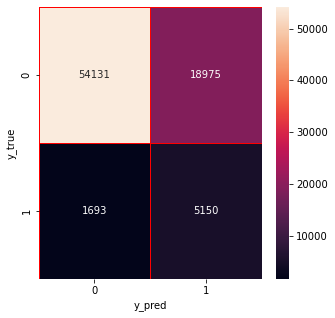

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     73106
           1       0.21      0.75      0.33      6843

    accuracy                           0.74     79949
   macro avg       0.59      0.75      0.59     79949
weighted avg       0.90      0.74      0.80     79949



In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_test_pred_rf_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf_rus))

This classification matrix is a good start, however if we dive into classification report, it will be much more helpful.

- Precision is a measure of how many of the positive predictions made are correct (true positives)
- Recall: over all the positive cases in the data, how many of the positive cases the classifier correctly predicted.
- F1-Score is a measure combining both precision and recall.

This classification report tells us that we will be 74% (0.74 recall for 1) correct in identifying the relevant target variable which is 1.

##### Random Forest - ADASYN

In [40]:
%time m_r.fit(X_adasyn, y_adasyn)

Wall time: 12min 16s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   scoring='f1')

In [41]:
m_r.best_score_

0.8346151117529323

In [42]:
m_r.best_params_

{'n_estimators': 9,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [43]:
rf_bp = m_r.best_params_

In [44]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [45]:
rf_classifier.fit(X_adasyn, y_adasyn)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=3,
                       n_estimators=9)

In [46]:
y_test_pred_rf_adasyn = rf_classifier.predict(X_test)
print(accuracy_score(y_test_pred_rf_adasyn, y_test))

0.8086405083240565



 AUC-ROC: 0.7219131749537911


Text(0.5, 0, 'False Positive Rate')

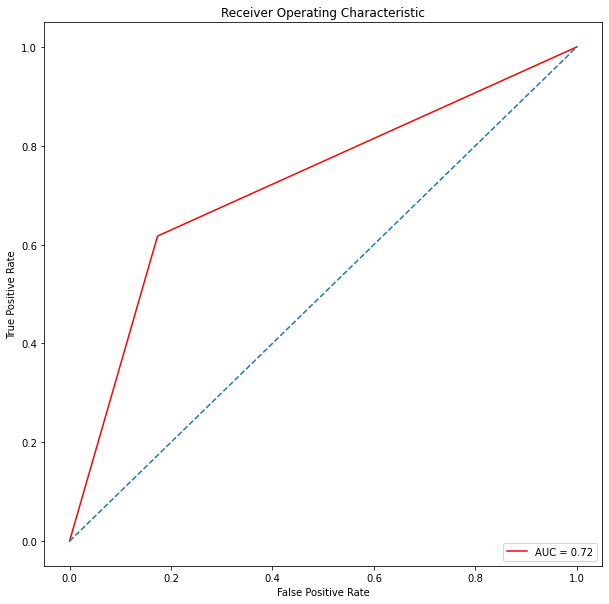

In [47]:
from sklearn import metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_test, y_test_pred_rf_adasyn))


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_rf_adasyn)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

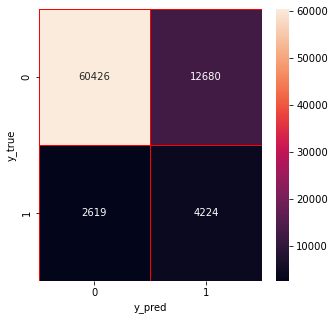

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     73106
           1       0.25      0.62      0.36      6843

    accuracy                           0.81     79949
   macro avg       0.60      0.72      0.62     79949
weighted avg       0.90      0.81      0.84     79949



In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_rf_adasyn)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf_adasyn))

Our target variable recall for class 1 has decreased from 0.74 to 0.60, in that way our under sampling model did better than over sampling, let us see if that stays the same with smote.

##### Random Forest - SMOTE

In [49]:
%time m_r.fit(X_smote, y_smote)

Wall time: 11min 26s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   scoring='f1')

In [50]:
m_r.best_score_

0.8366599434327059

In [51]:
m_r.best_params_

{'n_estimators': 9,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [52]:
rf_bp = m_r.best_params_

In [53]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [54]:
rf_classifier.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=9)

In [55]:
y_test_pred_rf_smote = rf_classifier.predict(X_test)
print(accuracy_score(y_test_pred_rf_smote, y_test))

0.8136562058312174



 AUC-ROC: 0.7173044616542521


Text(0.5, 0, 'False Positive Rate')

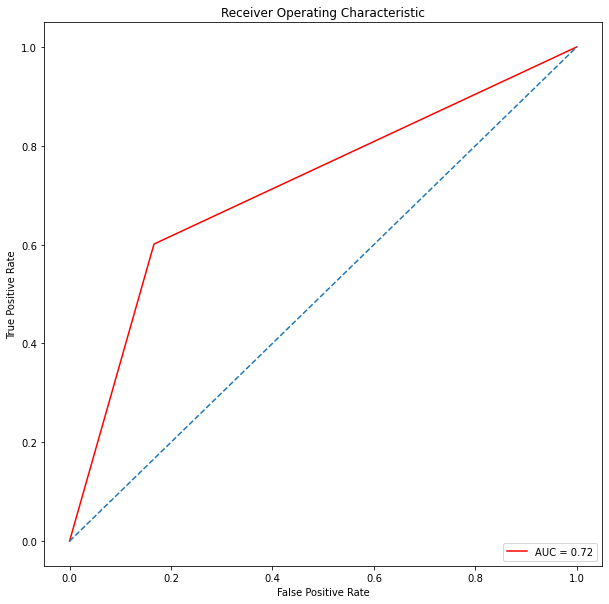

In [56]:
from sklearn import metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_test, y_test_pred_rf_smote))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_rf_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


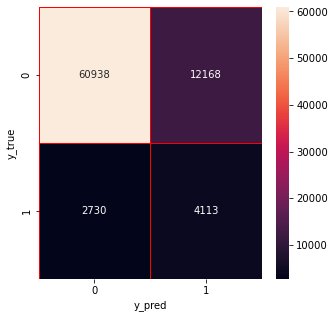

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     73106
           1       0.25      0.60      0.36      6843

    accuracy                           0.81     79949
   macro avg       0.60      0.72      0.62     79949
weighted avg       0.90      0.81      0.85     79949



In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_rf_smote)

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf_smote))

The Adasyn & Smote over sampling method are doing worse than RUS (Random Under Sampler) method for RF. The Roc_Auc more or less the same for all three, but the recall measure for our target variable class is 0.74 for RUS method, whereas 0.60 & 0.59 for ADASYN and SMOTE respectively.

### XGBoost

Again we will create a model and using RandomizedSearchCV to find the optimal parameters to run the model with. 

In [58]:
import xgboost as xgb

xb = xgb.XGBClassifier()

In [59]:
xb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [60]:
xb_param_grid = {
                 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                 "max_depth"        : [ 3, 5, 6, 8],
                 "min_child_weight" : [ 1, 3, 5, 7],
                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [61]:
xg_r = RandomizedSearchCV(param_distributions = xb_param_grid, 
                                    estimator = xb, scoring = "f1", 
                                    verbose = 0, n_iter = 10, cv = 5)


##### XGBoost - ADASYN

In [62]:
%time xg_r.fit(X_adasyn, y_adasyn)

Wall time: 14min 42s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [63]:
xg_r.best_score_

0.9129549554405113

In [64]:
xg_bp = xg_r.best_params_
xg_bp

{'min_child_weight': 3,
 'max_depth': 8,
 'learning_rate': 0.25,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [65]:
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

In [66]:
xg_classifier.fit(X_adasyn, y_adasyn)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [67]:
y_test_pred_xg_adasyn = xg_classifier.predict(X_test)
print(accuracy_score(y_test_pred_xg_adasyn, y_test))

0.8977598218864526


Text(0.5, 0, 'False Positive Rate')

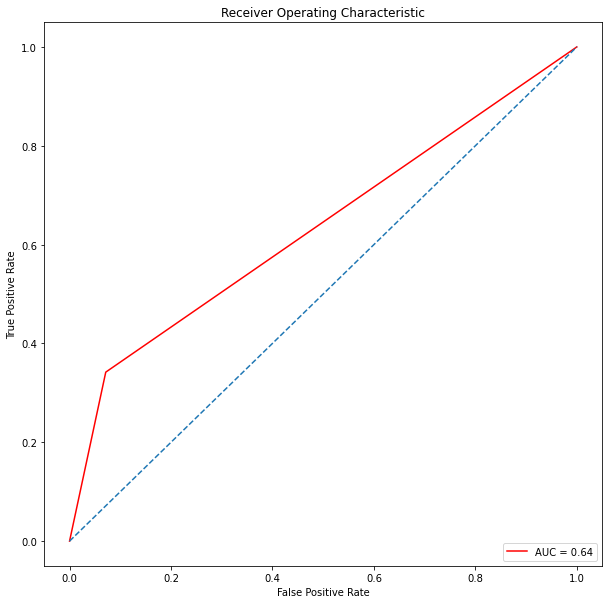

In [68]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pred_xg_adasyn, y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

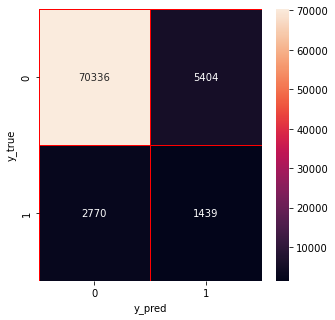

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     73106
           1       0.34      0.21      0.26      6843

    accuracy                           0.90     79949
   macro avg       0.64      0.59      0.60     79949
weighted avg       0.88      0.90      0.89     79949



In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_pred_xg_adasyn, y_test)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg_adasyn))

The oversampling technique with XGBoost has done the worst by far in recall score for the target class with 0.19.

##### XGBoost - SMOTE

In [70]:
%time xg_r.fit(X_smote, y_smote)

Wall time: 16min 54s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [71]:
xg_r.best_score_

0.9140652977485166

In [72]:
xg_bp = xg_r.best_params_
xg_bp

{'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [73]:
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

In [74]:
xg_classifier.fit(X_smote, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [75]:
y_test_pred_xg_smote = xg_classifier.predict(X_test)
print(accuracy_score(y_test_pred_xg_smote, y_test))

0.8972845188807865


Text(0.5, 0, 'False Positive Rate')

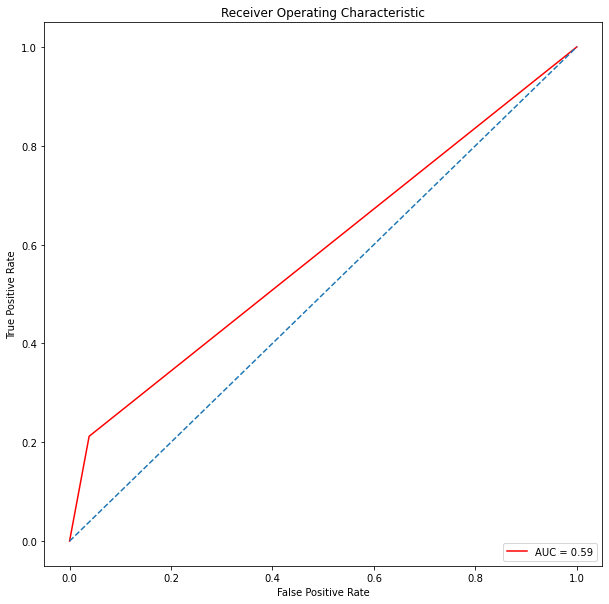

In [76]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_xg_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

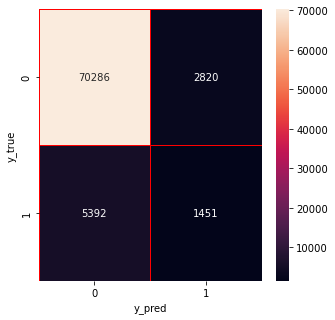

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     73106
           1       0.34      0.21      0.26      6843

    accuracy                           0.90     79949
   macro avg       0.63      0.59      0.60     79949
weighted avg       0.88      0.90      0.89     79949



In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_xg_smote)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg_smote))


Again, we see that oversampling method is leading us to a low recall score which we are trying to avoid.

##### XGBoost - RUS

In [78]:
%time xg_r.fit(X_rus, y_rus)

Wall time: 1min 18s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [79]:
xg_r.best_score_

0.7748461016502773

In [80]:
xg_bp = xg_r.best_params_
xg_bp

{'min_child_weight': 7,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [81]:
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

In [82]:
xg_classifier.fit(X_rus, y_rus)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [83]:
y_test_pred_xg_rus = xg_classifier.predict(X_test)
print(accuracy_score(y_test_pred_xg_rus, y_test))

0.7330298065016448


Text(0.5, 0, 'False Positive Rate')

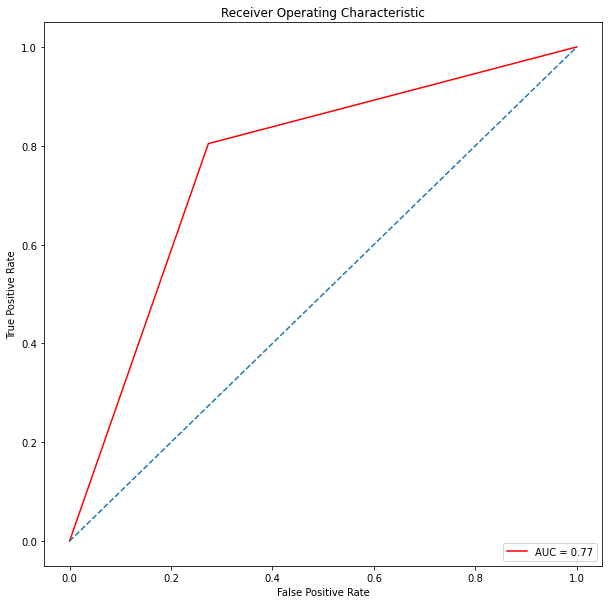

In [84]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_xg_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


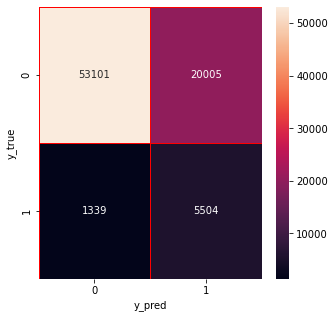

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.98      0.73      0.83     73106
           1       0.22      0.80      0.34      6843

    accuracy                           0.73     79949
   macro avg       0.60      0.77      0.59     79949
weighted avg       0.91      0.73      0.79     79949



In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_xg_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg_rus))


XGBoost with under sampling did the best by far in recall with 0.79, a 5 point jump from our previous best. We again see that undersampling provides us with low precision - high recall and oversampling does the opposite.

#### ADABoost_rus

Since ADABoost have two algorithms 'Samme' & 'Samme.R' we will generate 3 model for each algorithm and compare them.

In [86]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier_samme = AdaBoostClassifier(algorithm = 'SAMME', n_estimators = 1000)

In [87]:
%time ada_classifier_samme.fit(X_rus, y_rus)

Wall time: 33.3 s


AdaBoostClassifier(algorithm='SAMME', n_estimators=1000)

In [88]:
y_test_pred_ada_samme_rus = ada_classifier_samme.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_rus, y_test))

0.7547436490762861


Text(0.5, 0, 'False Positive Rate')

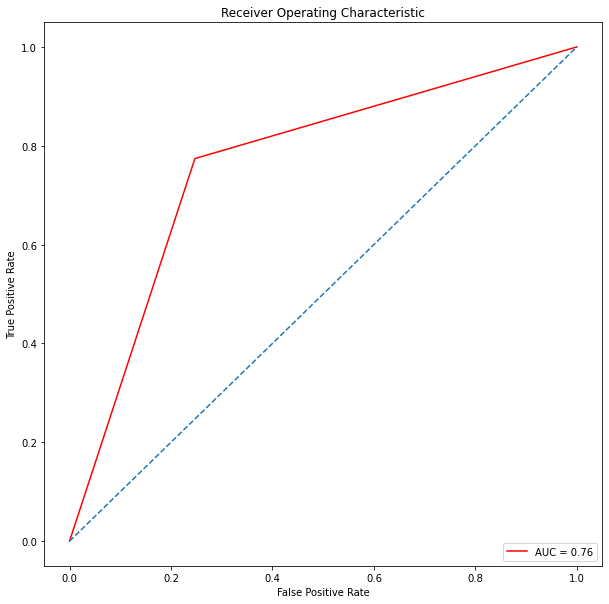

In [89]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

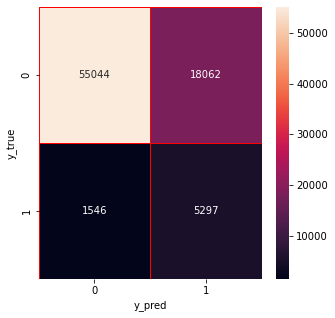

In [90]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [129]:
from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

y_train_pred_ada_samme_rus = ada_classifier_samme.predict(X_rus)


print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_rus))


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     73106
           1       0.23      0.77      0.35      6843

    accuracy                           0.75     79949
   macro avg       0.60      0.76      0.60     79949
weighted avg       0.91      0.75      0.81     79949



##### ADABoost_adasyn - SAMME

In [92]:
%time ada_classifier_samme.fit(X_adasyn, y_adasyn)

Wall time: 8min 34s


AdaBoostClassifier(algorithm='SAMME', n_estimators=1000)

In [93]:
y_test_pred_ada_samme_adasyn = ada_classifier_samme.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_adasyn, y_test))

0.8751829291173123


Text(0.5, 0, 'False Positive Rate')

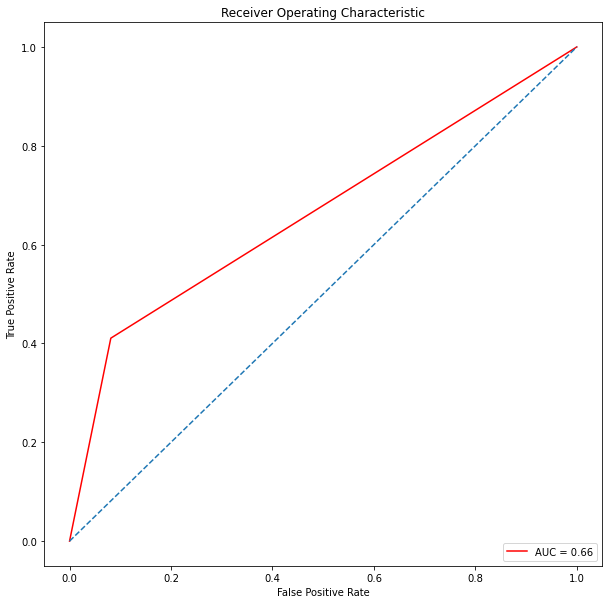

In [94]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_adasyn)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

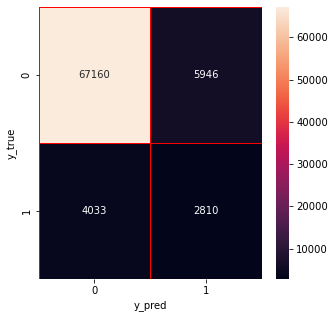

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     73106
           1       0.32      0.41      0.36      6843

    accuracy                           0.88     79949
   macro avg       0.63      0.66      0.65     79949
weighted avg       0.89      0.88      0.88     79949



In [95]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_adasyn)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_adasyn))

##### ADABoost_smote - SAMME


In [96]:
%time ada_classifier_samme.fit(X_smote, y_smote)

Wall time: 9min 4s


AdaBoostClassifier(algorithm='SAMME', n_estimators=1000)

In [97]:
y_test_pred_ada_samme_smote = ada_classifier_samme.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_smote, y_test))

0.8746701021901462


Text(0.5, 0, 'False Positive Rate')

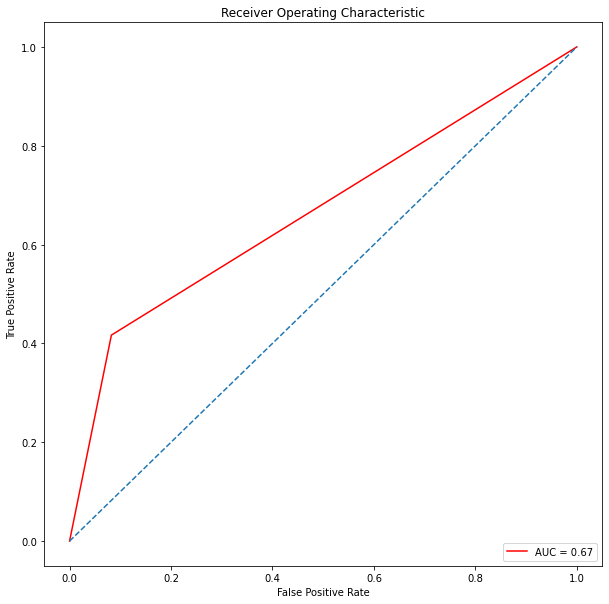

In [98]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

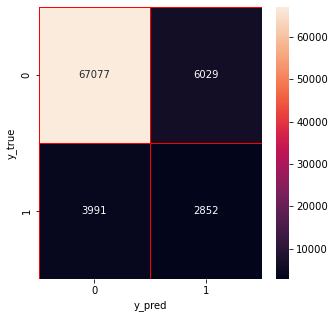

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_smote)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [130]:
from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

y_train_pred_ada_samme_smote = ada_classifier_samme.predict(X_smote)

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_smote))


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     73106
           1       0.32      0.42      0.36      6843

    accuracy                           0.87     79949
   macro avg       0.63      0.67      0.65     79949
weighted avg       0.89      0.87      0.88     79949



We see the same pattern as before, our over sampling method is performing better than the under sampling method, with the number of correct predictions again over 90% and weighted f1 score 3 units below our best model which was XGBoost with ADASYN sampling method. 

##### ADABoost_rus - SAMME.R


In [101]:
ada_classifier_samme_r = AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 1000)

In [102]:
%time ada_classifier_samme_r.fit(X_rus, y_rus)

Wall time: 39.1 s


AdaBoostClassifier(n_estimators=1000)

In [103]:
y_test_pred_ada_samme_r_rus = ada_classifier_samme_r.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_r_rus, y_test))

0.7508286532664573


Text(0.5, 0, 'False Positive Rate')

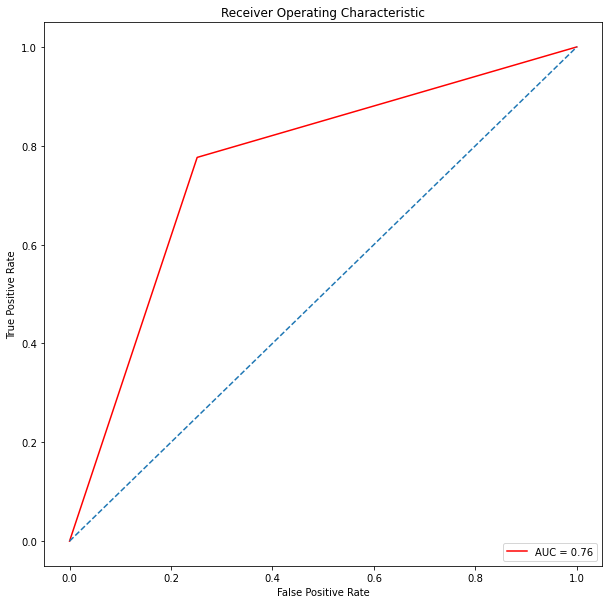

In [104]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_r_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

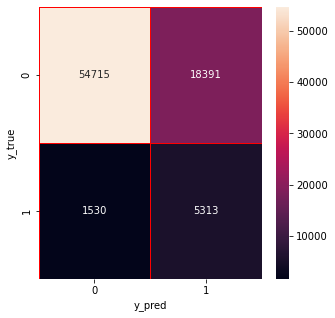

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     73106
           1       0.22      0.78      0.35      6843

    accuracy                           0.75     79949
   macro avg       0.60      0.76      0.60     79949
weighted avg       0.91      0.75      0.80     79949



In [105]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_r_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_r_rus))

##### ADABoost_adasyn - SAMME.R

In [106]:
%time ada_classifier_samme_r.fit(X_adasyn, y_adasyn)

Wall time: 9min 10s


AdaBoostClassifier(n_estimators=1000)

In [107]:
y_test_pred_ada_samme_r_adasyn = ada_classifier_samme_r.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_r_adasyn, y_test))

0.9063778158576092


Text(0.5, 0, 'False Positive Rate')

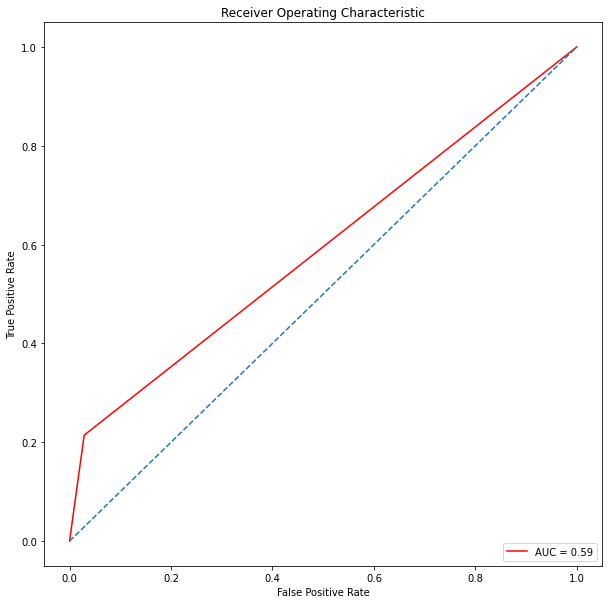

In [108]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_r_adasyn)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

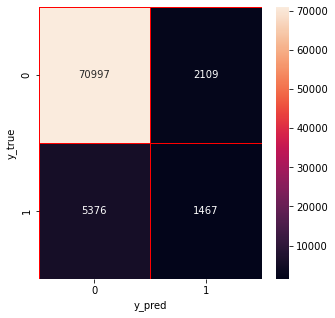

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     73106
           1       0.41      0.21      0.28      6843

    accuracy                           0.91     79949
   macro avg       0.67      0.59      0.62     79949
weighted avg       0.89      0.91      0.89     79949



In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_r_adasyn)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_r_adasyn))

##### ADABoost_smote - SAMME.R


In [110]:
%time ada_classifier_samme_r.fit(X_smote, y_smote)

Wall time: 9min 44s


AdaBoostClassifier(n_estimators=1000)

In [111]:
y_test_pred_ada_samme_r_smote = ada_classifier_samme_r.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_r_smote, y_test))

0.9059525447472764


Text(0.5, 0, 'False Positive Rate')

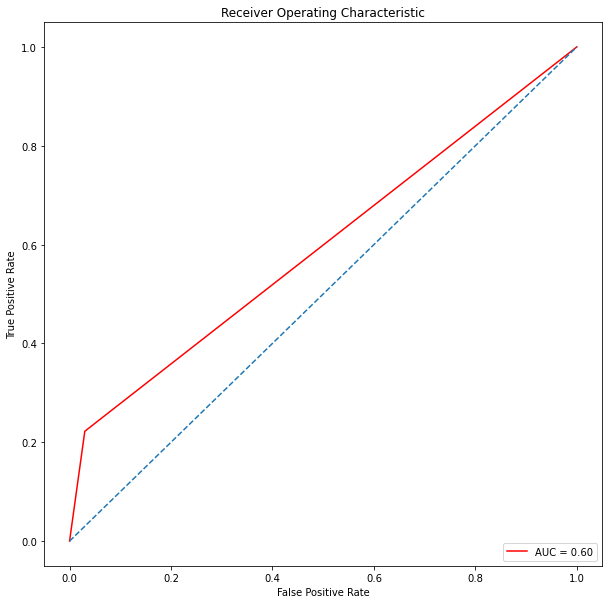

In [112]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_r_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

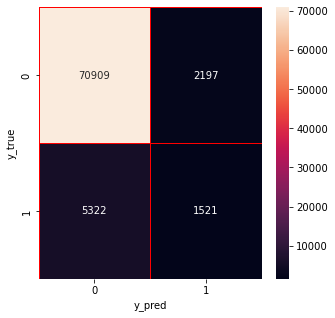

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     73106
           1       0.41      0.22      0.29      6843

    accuracy                           0.91     79949
   macro avg       0.67      0.60      0.62     79949
weighted avg       0.89      0.91      0.89     79949



In [113]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_r_smote)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_r_smote))

In [133]:
data = {
    'Model': ['Random Forest', 'Random Forest', 'Random Forest', 'XGBoost', 'XGBoost', 'XGBoost', 'ADABoost', 'ADABoost',  'ADABoost', 'ADABoost_SAMME.R', 'ADABoost_SAMME.R', 'ADABoost_SAMME.R'],
    'Sampling': ['RUS', 'ADASYN', 'SMOTE', 'RUS', 'ADASYN', 'SMOTE', 'RUS', 'ADASYN', 'SMOTE', 'RUS', 'ADASYN', 'SMOTE'],
    '0: Precision': [0.97, 0.96, 0.96, 0.98, 0.93, 0.93, 0.97, 0.94, 0.94, 0.97, 0.93, 0.93],
    '0: Recall': [0.74, 0.83, 0.83, 0.73, 0.96, 0.96, 0.75, 0.92, 0.92, 0.75, 0.97, 0.97],
    '1: Precision': [0.21, 0.25, 0.25, 0.22, 0.34, 0.34, 0.23, 0.32, 0.32, 0.22, 0.41, 0.41],
    '1: Recall': [0.75, 0.62, 0.60, 0.82, 0.21, 0.21, 0.77, 0.41, 0.42, 0.78, 0.21, 0.22]}

df = pd.DataFrame(data)
df

,Model,Sampling,0: Precision,0: Recall,1: Precision,1: Recall
0,Random Forest,RUS,0.97,0.74,0.21,0.75
1,Random Forest,ADASYN,0.96,0.83,0.25,0.62
2,Random Forest,SMOTE,0.96,0.83,0.25,0.60
3,XGBoost,RUS,0.98,0.73,0.22,0.82
4,XGBoost,ADASYN,0.93,0.96,0.34,0.21
5,XGBoost,SMOTE,0.93,0.96,0.34,0.21
6,ADABoost,RUS,0.97,0.75,0.23,0.77
7,ADABoost,ADASYN,0.94,0.92,0.32,0.41
8,ADABoost,SMOTE,0.94,0.92,0.32,0.42
9,ADABoost_SAMME.R,RUS,0.97,0.75,0.22,0.78


In [135]:
df.sort_values(by=['1: Recall'], ascending = False)

,Model,Sampling,0: Precision,0: Recall,1: Precision,1: Recall
3,XGBoost,RUS,0.98,0.73,0.22,0.82
9,ADABoost_SAMME.R,RUS,0.97,0.75,0.22,0.78
6,ADABoost,RUS,0.97,0.75,0.23,0.77
0,Random Forest,RUS,0.97,0.74,0.21,0.75
1,Random Forest,ADASYN,0.96,0.83,0.25,0.62
2,Random Forest,SMOTE,0.96,0.83,0.25,0.60
8,ADABoost,SMOTE,0.94,0.92,0.32,0.42
7,ADABoost,ADASYN,0.94,0.92,0.32,0.41
11,ADABoost_SAMME.R,SMOTE,0.93,0.97,0.41,0.22
4,XGBoost,ADASYN,0.93,0.96,0.34,0.21


In [116]:
probability = xg_r.predict_proba(X_rus)  #[:,1] # to get the probability of Class 1.
probabilities = pd.DataFrame(probability, columns = ['Prob of Heart Disease (0)', 'Prob of Heart Disease (1)'])
print(probabilities.head())

   Prob of Heart Disease (0)  Prob of Heart Disease (1)
0                   0.918839                   0.081161
1                   0.566849                   0.433151
2                   0.881119                   0.118881
3                   0.867723                   0.132277
4                   0.452055                   0.547945


In [117]:
pd.cut(probabilities['Prob of Heart Disease (1)'], bins = 5).value_counts()

(0.0134, 0.209]    10452
(0.599, 0.794]      9637
(0.794, 0.989]      8799
(0.404, 0.599]      6534
(0.209, 0.404]      5638
Name: Prob of Heart Disease (1), dtype: int64

 * 0 - 0.2 = Strong negative
 * 0.2 - 0.79 = The patient needs
 * 0.79 - 1 = Strong Positive

In [118]:
print(probabilities.head())
probabilities.dtypes

   Prob of Heart Disease (0)  Prob of Heart Disease (1)
0                   0.918839                   0.081161
1                   0.566849                   0.433151
2                   0.881119                   0.118881
3                   0.867723                   0.132277
4                   0.452055                   0.547945


Prob of Heart Disease (0)    float32
Prob of Heart Disease (1)    float32
dtype: object

The precision score is: 0.72
The recall score is: 0.88 

Accuracy score is: 0.77
The F1 score is: 0.79


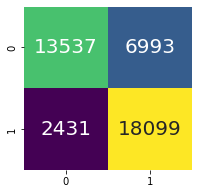

In [138]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

discrimination_threshold = 0.4
predictions = xg_r.predict_proba(X_rus)
predictions = (predictions[::,1] > discrimination_threshold )*1

print("The precision score is: %.2f" % precision_score(y_rus, predictions))
print("The recall score is: %.2f" % recall_score(y_rus, predictions), "\n")
print("Accuracy score is: %.2f" % accuracy_score(y_rus, predictions))
print("The F1 score is: %.2f" % f1_score(y_rus, predictions))

cm = confusion_matrix( y_rus , predictions)
plt.figure(figsize = (3,3))
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt="d", cmap="viridis", cbar=False)
plt.show()

[0.00000000e+00 4.87092060e-05 1.37847053e-02 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.         0.         0.         ... 0.9994642  0.99956162 1.        ]
[1.988792   0.9887919  0.96352893 ... 0.01976725 0.01929112 0.01441145]
0.8613723385804671
Threshold value is: 0.51919246


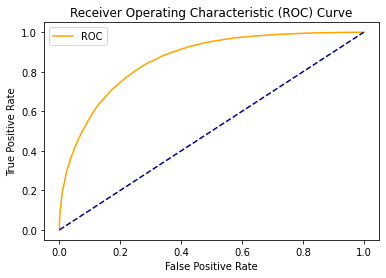

In [124]:
from sklearn.metrics import roc_auc_score


def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_scores = xg_r.predict_proba(X_rus)[:, 1]




fpr, tpr, thresholds = roc_curve(y_rus, y_scores)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_rus, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

We see that it is not possible to have a high precision and high recall score, there is a tradeoff. The under sampling method gives us high recall mainly because it is "under sampled" and, we correctly identified as having a heart disease (for less points), for all the patients who actually have heart disease, thus low precision high recall (More False positive). On the other hand, with over sampling and having more data points, we achieve the high precision and low recall scenario, where our model will be more certain if a patient has heart disease or not. 

Our problem as stated by clients want to completely avoid any situations where the patient has heart disease, but our model classifies as him not having it. In other words, the opportunity cost on passing up on a true positive case is significantly higher than acting on a False positive cases.

XGBoost with the Random Under Sampler has the best recall with 0.82 for our target variable in test set, and by lowering the threshold, we have achieved a precision of 0.72, and recall of 0.82. 